# Football and Manchester United

As a Manchester United supporter

For this analysis, I am using data from the Open Football project, which provides open public domain football data in CSV format (https://footballcsv.github.io/) for download. The Open Football project provides data from many leagues across the world, however, I will be focusing on the top division of English football for which data is provided between most of the years between 1888 to 2020.

This project demonstrates the following:

A. Preparing the dataset
- Creating the desired dataset(s) - creating functions which create pandas dataframes for any variation of English top division seasons.
- Cleaning and enhancing the dataset - dealing with missing data and enhancing the dataset by adding additional information inferred from the existing data.
- Filtering the data - adding functions which filter the data by team results, matchups, and adding team-specific statistics.
- Managing the data - adding all of the functions as methods to a class to quickly and conveniently create these filtered subsets of the data and populate a dataframe for exploratory data analysis.

B. Exploratory Data Analysis
- Goals scored over time
- Relative strengths of winners and losers over time
- Home advantage

C. Analysing the Sir Alex Ferguson era
- How successful was the Sir Alex Ferguson era of Manchester United (1986-2013)? How does it compare to the years since?
- Does Manchester United live up to their reputation as comeback kings?

D. Final Thoughts (visualised)

# A. Preparing the dataset

There are a number of wrinkles with the data that will require some adjustments before we can begin the analysis proper.

## Creating the desired dataset(s)
Firstly, the download provides CSV files for each available season in separate folders - by decade, season, and then finally CSV files for each division. 

For example, the path to the CSV file containing results from the 2019-20 season of the English Premier League (the top division of English football) is:

> */path to folder/England-master/2010s/2019-20/eng.1.csv*

For flexibility, we want to be able to access any individual season for which there is data, as well as the ability to merge them into a single dataset.

For this purpose, we have a function that populates a dictionary with the correct paths for each CSV:

In [158]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

#This creates a dictionary with paths to each season's CSV file. You can modify the number of seasons by decade.
def seasons_dictionary(starting_decade, ending_decade):
    eng = 'D:\Google Drive\\New Dropbox\Work stuff\Professional Development\Data Projects\Football_python\england-master'
    #Populate a dictionary with a string like '2010s' as the key and a string like '2010-11' as the value
    seasons = {}
    for i in range(int(abs((starting_decade - ending_decade)/10)) + 1):
        decade = starting_decade
        decade_string = str(decade) + 's'
        list_of_seasons = []
        for i in range(10):
            season = str(decade + i) + '-' + str(decade + i + 1)[2:4]
            list_of_seasons.append(season)
            seasons[decade_string] = list_of_seasons
        starting_decade += 10
    #Using the dictionary above, populate another dictionary with a string like 'df_eng_2010-11" as the key, and the path to the file for the 2010-11 season as the value.
    df_dictionary = {}
    for decade in seasons:
        for season in seasons[decade]:
            path = eng + '\\' + decade + '\\' + season + '\eng.1.csv'
            df_name = 'df_eng_' + season
            df_dictionary[df_name] = path
    return df_dictionary

#To return the paths for every season in the 2010s:
seasons_dictionary(2010, 2010)

{'df_eng_2010-11': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2010-11\\eng.1.csv',
 'df_eng_2011-12': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2011-12\\eng.1.csv',
 'df_eng_2012-13': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2012-13\\eng.1.csv',
 'df_eng_2013-14': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2013-14\\eng.1.csv',
 'df_eng_2014-15': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2014-15\\eng.1.csv',
 'df_eng_2015-16': 'D:\\Google Drive\\New Dropbox\\Work stuff\\Professional Development\\Data Projects\\Football_python\\england-master\\2010s\\2015-16\\eng.1.csv',
 'df_eng_2

Using the dictionary produced by this function, we can then specify any individual season (CSV file) to read in to a pandas dataframe.

In [160]:
#Creates a data frame from the CSV file of the specified season
def create_df(season):
    all_seasons = seasons_dictionary(1880, 2010)
    all_seasons['df_eng_' + season]
    df = pd.read_csv(all_seasons['df_eng_' + season])
    return df

#for the sake of readability, this function will display a certain amount of rows in the df
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

#For example, here's a snapshot of the 2014-15 Premier League season:
EPL_14_15 = create_df('2014-15')
display_n(EPL_14_15, 2)

,Round,Date,Team 1,FT,HT,Team 2
0,?,(Sat) 16 Aug 2014 (W33),Arsenal FC (1),2-1,1-1,Crystal Palace FC (1)
1,?,(Sat) 16 Aug 2014 (W33),Leicester City FC (1),2-2,1-2,Everton FC (1)
...,...,...,...,...,...,...
378,?,(Sun) 24 May 2015 (W21),Newcastle United FC (38),2-0,0-0,West Ham United FC (38)
379,?,(Sun) 24 May 2015 (W21),Stoke City FC (38),6-1,5-0,Liverpool FC (38)


We also want to be able to look at more than a single season, even though the data is contained in separate CSV files. Building on the seasons_dictionary function again, we can read in and merge the CSV files for multiple seasons. To delineate the data for each season, we will also add a column for each season's dataframe before we merge them together.  

Note that we could easily do the same for the different leagues as well, we would just need to accomodate another parameter which specifies the file name - e.g., a parameter of 1 could select the 'eng.1.csv' filename in the generated path, 2 could select 'eng.2.csv' etc. For the purposes of this analysis we'll be sticking to the first division ('eng.1.csv') files - with over a century of fixtures to pore over, that will be plenty.

Note that not every year has data. There were interruptions to professional football, most notably during the years of the World Wars. The function has accommodated for this with error handling.

Below, we use the merge_df function below to create a data frame containing *all* the available data for top flight English football, from the 1888-89 seasons to the 2019-20 season.

In [162]:
#Finally, this function reads in any number of season datasets as specified in the argument, and merges them into a single dataframe
def merge_df(start_season, end_season):
    df_dictionary = seasons_dictionary(1880, 2010)
    df_list = []
    seasons_list = []
    #Identify the index of the starting season and ending season specified
    start_index = list(df_dictionary.keys()).index('df_eng_' + start_season)
    end_index = (list(df_dictionary.keys()).index('df_eng_' + end_season)) + 1
    #Loop through these indices to populate the seasons_list with the desired keys for seasons_dictionary
    for i in range(start_index, end_index):
        season_key = list(df_dictionary.keys())[i]
        seasons_list.append(season_key)
    #Use the keys in seasons_list to fetch the paths to each season, and reading them in to a list of dfs in df_list
    for i in df_dictionary:
        if i in seasons_list:
            try:
                df = pd.read_csv(df_dictionary[i], index_col=None, header=0)
    #While we're at it, use regex to isolate the season for each CSV file, and add it as a column to the dataframe before appending it to df_list
                season = re.findall(r'\d\d\d\d-\d\d', i)[0]
                df['Season'] = season
                df_list.append(df)
            except FileNotFoundError: #This exception accommodates the fact that data is not available for all years - for example, seasons that were not played due to WW1 and WW2.
                continue
    #Finally, merge the dfs in df_list into a single df
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)
    return merged_df

#Let's make use of all the available data, from the 1888-89 season to the current 2019-20 season.
merged_df = merge_df('1888-89', '2019-20')
display_n(merged_df, 2)

,Round,Date,Team 1,FT,HT,Team 2,Season
0,?,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89
1,?,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89
...,...,...,...,...,...,...,...
48989,?,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20
48990,?,(Mon) 9 Mar 2020 (W11),Leicester City FC (29),4-0,1-0,Aston Villa FC (28),2019-20


As we can see, the merged dataset starts on the 8th September 1888 and it ends 48,991 games and 132 years later, with a game on 9th March 2020.

## Cleaning and enhancing the dataset

Now that we have the means to quickly and easily create different datasets from the data we have available, there is some cleaning to do:

- The dataset has missing data in the "Round" and "HT" columns. They are marked by the '?' symbol.
- The FT (full time) and HT (half time) scores are represented as strings, not numbers.
- We must infer the goals scored by the home and away teams by the order of the string. '4-0' means the home team scored 4 goals to the away team scored 0 goals.

It would be nice (and much more useful) to be able to deal with these scores as numbers, and to have the goals explicitly attributed to the home or away teams.

To clean and enhance the dataset, we will need to:
- Get rid of the "Round" column - the vast majority of seasons have missing data for this column, and it is useless for our analysis.
- Add some columns which provide ways for us to cut the data, such as the number of goals scored by the home vs. away teams, the total number of goals scored, as well as goals scored in the first half vs. the second half.
- Find a way to handle the missing half-time scores when it comes to statistics which rely on that information.

In [164]:
#Let's add some additional columns with data that will be useful for analysis
def add_columns(dataframe):
    df = dataframe
    #The below converts a string '2-1' to a list [2,1] for the FT and HT columns
    FT_score_list = df['FT'].map(lambda FT: re.findall(r'\d+', FT)) 
    HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
    #Now that we have the scores in a list format, we can convert them to integers and play with them to create the following additional statistics:
    df['Total goals'] = FT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]))
    df['Home goals'] = FT_score_list.map(lambda goals: int(goals[0]))
    df['Away goals'] = FT_score_list.map(lambda goals: int(goals[1])) 
    df['First half goals'] = HT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]) if goals != [] else np.NaN) #The if/else condition is necessary because for many games the HT result is missing. They are marked as NaN if so.
    df['Second half goals'] = df['Total goals'] - df['First half goals']
    #Finally, delete the useless "round" column
    df = df.drop(columns=['Round'])
    return df

merged_df = add_columns(merged_df)
display_n(merged_df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
0,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89,9,3,6,NaN,NaN
1,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89,2,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
48989,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1.0,1.0
48990,(Mon) 9 Mar 2020 (W11),Leicester City FC (29),4-0,1-0,Aston Villa FC (28),2019-20,4,4,0,1.0,3.0


## Filtering the data

Again, it would be useful to have some way to quickly isolate certain information to allow for the analysis of a particular team's performance. Additional team-specific statistics must also be added. It would be great if we could:
- Analyse a particular team's performance by looking up their results.
- Look up particular matchups between two teams.
- Add team-specific information such as the goals scored by the team, goals scored against the team, and to identify whether they are scored in the first or second half (where HT stats are available). Moreover, we can infer wins, losses, and draws.

Let's start with a function that will find a particular team's games (specified by the 'name' argument) over any given period (specified by the 'df' argument). It should also add some team-specific statistics, such as the number of goals scored by the team, against the team, whether it was a win or loss, etc. We want it to be able to find multiple teams if necessary.

In [166]:
#Look up a particular team's fixtures, it will take any number of team names as arguments, to create a df with all those team's fixtures across a given period of time.
def find_team_games(df, *team_names):
    #use a for loop to loop through each team in *teams, creating a df with that team's fixtures, adding team stats, and then appending it to df_list
    df_list = []
    for team in team_names:
        #Create a df with the team's fixtures only
        team_df = df.loc[(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)].copy()
         #This line is needed for when multiple teams are selected - e.g., if I wanted Manchester United and Everton fixtures, then the result for games where Manchester United and Everton played each other will be 'duplicated' but the team-specific stats will be different. The first row generated will show the team stats from one team, and the 'duplicated' rows will show the team stats from the other team. This will create a column which will tell us from which perspective the team stats are being reported.
        team_df['Team'] = team
        #Add team-specific stats as columns to the df
        team_df['Team goals'] = np.where(team_df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, team_df['Home goals'], team_df['Away goals'])
        HT_score_list = team_df['HT'].map(lambda HT: re.findall(r'\d+', HT))
        team_df['Team goals (1st half)'] = np.where(team_df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
        team_df['Team goals (2nd half)'] = team_df['Team goals'] - team_df['Team goals (1st half)']
        team_df['Goals against'] = team_df['Total goals'] - team_df['Team goals']
        team_df['Goals against (1st half)'] = team_df['First half goals'] - team_df['Team goals (1st half)']
        team_df['Goals against (2nd half)'] = team_df['Second half goals'] - team_df['Team goals (2nd half)']
        team_df['Goal difference'] = team_df['Team goals'] - team_df['Goals against']
        team_df['Result'] = np.select([team_df['Team goals'] > team_df['Goals against'], team_df['Team goals'] < team_df['Goals against']],['Win', 'Loss'], default = 'Draw')
        team_df['Points'] = np.select([team_df['Team goals'] > team_df['Goals against'], team_df['Team goals'] < team_df['Goals against']],[3, 0], default = 1)
        #append this df to df_list
        df_list.append(team_df)
    #Combine the df's for each specified team into one df, sorting them by date
    team_df = pd.concat(df_list).sort_index(ascending=True)
    return team_df

#Let's find Manchester United and Arsenal results from the 1985-86 to 1990-91 season
merged_df = add_columns(merge_df('1985-86', '1990-91'))
df = find_team_games(merged_df,'Manchester United', 'Arsenal')
display_n(df, 3)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Team,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
4,(Sat) 17 Aug 1985 (32),Manchester United FC (1),4-0,?,Aston Villa FC (1),1985-86,4,4,0,NaN,...,Manchester United,4,NaN,NaN,0,NaN,NaN,4,Win,3
9,(Sat) 17 Aug 1985 (32),Liverpool FC (1),2-0,?,Arsenal FC (1),1985-86,2,2,0,NaN,...,Arsenal,0,NaN,NaN,2,NaN,NaN,-2,Loss,0
11,(Tue) 20 Aug 1985 (33),Ipswich Town FC (2),0-1,?,Manchester United FC (2),1985-86,1,0,1,NaN,...,Manchester United,1,NaN,NaN,0,NaN,NaN,1,Win,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,(Sat) 11 May 1991 (18),Crystal Palace FC (38),3-0,?,Manchester United FC (37),1990-91,3,3,0,NaN,...,Manchester United,0,NaN,NaN,3,NaN,NaN,-3,Loss,0
2477,(Sat) 11 May 1991 (18),Arsenal FC (38),6-1,?,Coventry City FC (38),1990-91,7,6,1,NaN,...,Arsenal,6,NaN,NaN,1,NaN,NaN,5,Win,3
2483,(Mon) 20 May 1991 (20),Manchester United FC (38),1-1,?,Tottenham Hotspur FC (38),1990-91,2,1,1,NaN,...,Manchester United,1,NaN,NaN,1,NaN,NaN,0,Draw,1


Next, let's create a function that will make a dataframe for games against two particular teams. Again the 'df' argument specifies the time period, and 'team1' and 'team2' the two teams in the matchup.

In [168]:
#Look up the fixtures for a particular matchup
def find_matchups(df, team1, team2):
    matchups = df.loc[(df['Team 1'].str.contains((team1), re.compile('(\d)|(\d\d)')) == True) & (df['Team 2'].str.contains((team2), re.compile('(\d)|(\d\d)')) == True) | (df['Team 1'].str.contains((team2), re.compile('(\d)|(\d\d)')) == True) & (df['Team 2'].str.contains((team1), re.compile('(\d)|(\d\d)')) == True)]
    return matchups

#Let's look at the games between Manchester United and Liverpool
north_west_derby = find_matchups(merged_df, 'Manchester United', 'Liverpool')
display_n(north_west_derby, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
140,(Sat) 19 Oct 1985 (41),Manchester United FC (13),1-1,?,Liverpool FC (13),1985-86,2,1,1,NaN,NaN
307,(Sun) 9 Feb 1986 (5),Liverpool FC (29),1-1,?,Manchester United FC (28),1985-86,2,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2154,(Sun) 16 Sep 1990 (37),Liverpool FC (5),4-0,?,Manchester United FC (6),1990-91,4,4,0,NaN,NaN
2341,(Sun) 3 Feb 1991 (4),Manchester United FC (24),1-1,?,Liverpool FC (23),1990-91,2,1,1,NaN,NaN


## Managing the Data

Now that we have functions which can filter the data to seasons, teams, and matchups, as well as add additional information for analysis, stringing these functions together can get complicated and not very intuitive to read. For example, if I wanted to get a df with Arsenal, Chelsea, Liverpool, and Manchester United results from the last 20 seasons, it would look like this:

> find_team_games(add_columns(merge_df('2000-01', '2019-20')), 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester United')

Alternatively, for readability you could split it out like this:

> seasons = merge_df('2000-01','2019-20')

> seasons = add_columns(seasons)

> teams = find_team_games(seasons, 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester United')

Let's wrap this all up into a class so that we can make use of the functions without having to chain them together like this. We should write it so that it's fairly intuitive to understand the contents of the df being produced.

Here's the functionality of the above functions written into a class called "FootballData" with three methods:
- .create_df() creates a dataset from any specified range of available seasons, including the additional inferred data from the "add_columns()" function from above.
- .get_team_stats() creates and filters the dataset to a particular team(s)' fixtures, and adds the additional team-specific data columns from the "find_team_games()" function above.
- .get_matchups() creates and filters the dataset to a particular matchup between two teams, and adds additional match-up specific data, similar to the team specific data in .get_team_stats().

In [170]:
class FootballData(object):
    def __init__(self, start_season, end_season):
        self.start_season = start_season
        self.end_season = end_season
    def create_df(self):
        def seasons_dictionary(starting_decade, ending_decade):
            #Create a dictionary with the decades and seasons for each dataset.
            eng = 'D:\Google Drive\\New Dropbox\Work stuff\Professional Development\Data Projects\Football_python\england-master'
            seasons = {}
            for i in range(int(abs((starting_decade - ending_decade)/10)) + 1):
                decade = starting_decade
                decade_string = str(decade) + 's'
                list_of_seasons = []
                for i in range(10):
                    season = str(decade + i) + '-' + str(decade + i + 1)[2:4]
                    list_of_seasons.append(season)
                    seasons[decade_string] = list_of_seasons
                starting_decade += 10
            df_dictionary = {}
            for decade in seasons:
                for season in seasons[decade]:
                    path = eng + '\\' + decade + '\\' + season + '\eng.1.csv'
                    df_name = 'df_eng_' + season
                    df_dictionary[df_name] = path
            return df_dictionary
        df_dictionary = seasons_dictionary(1880, 2010)
        df_list = []
        seasons_list = []
        #Identify the index of the starting season and ending season specified
        start_index = list(df_dictionary.keys()).index('df_eng_' + self.start_season)
        end_index = (list(df_dictionary.keys()).index('df_eng_' + self.end_season)) + 1
        #Iterate through these indices to populate the seasons_list with the desired keys for seasons_dictionary
        for i in range(start_index, end_index):
            season_key = list(df_dictionary.keys())[i]
            seasons_list.append(season_key)
        #Use the keys in seasons_list to fetch the paths to each season, and reading them in to a list of dfs in df_list
        for i in df_dictionary:
            if i in seasons_list:
                try:
                    season = re.findall(r'\d\d\d\d-\d\d', i)[0]
                    df = pd.read_csv(df_dictionary[i], index_col=None, header=0)
                    df['Season'] = season
                    df_list.append(df)
                except FileNotFoundError: #This exception accommodates the fact that data is not available for all years - for example, seasons that were not played due to WW1 and WW2.
                    continue
        #Finally, merge the dfs in df_list into a single df
        df = pd.concat(df_list, axis =0, ignore_index=True)
        FT_score_list = df['FT'].map(lambda FT: re.findall(r'\d+', FT)) #This converts the string '2-1' to a list [2,1]
        HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
        df['Total goals'] = FT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]))
        df['Home goals'] = FT_score_list.map(lambda goals: int(goals[0])) #note the use of the map() - it seems like applying functions is done as methods when working with dataframes
        df['Away goals'] = FT_score_list.map(lambda goals: int(goals[1])) #I have forced them to be int types because they come from a string (e.g., 2-1) - if python doesn't recognise it as a number then descriptive statistics will be different
        df['First half goals'] = HT_score_list.map(lambda goals: int(goals[0]) + int(goals[1]) if goals != [] else np.NaN) #NOTE:the if condition is necessary because for many games the HT result is missing. They are marked as NaN if so.
        df['Second half goals'] = df['Total goals'] - df['First half goals']
        df = df.drop(columns=['Round']) #Note: In order for the change to take place, you need to re-assign it to the dataframe. you can't just use the method
        return df
    def get_team_stats(self, *teams):
        self.df = FootballData(self.start_season, self.end_season).create_df()
        self.teams = teams
        df_list = []
        if teams[0] == 'all':
        #Removes the (1) part from the Team 1 column, then lists each unique team in the dataset - I found that I also needed to strip the strings of any trailing spaces as it created duplicates to inconsistency with the data formatting in the cSV.
            all_teams = self.df['Team 1'].str.replace(re.compile('\d[()]|[()]\d|(?<!:)[()]'),'').str.strip().unique()
            for team in all_teams:
                df = self.df.loc[(self.df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)].copy()
                #This line is needed for when multiple teams are selected - e.g., if I wanted Manchester United and Everton fixtures, then the result for games where Manchester United and Everton played each other will be 'duplicated' but the team-specific stats will be different. The first row generated will show the team stats from one team, and the 'duplicated' rows will show the team stats from the other team. This will create a column which will tell us from which perspective the team stats are being reported. This will be important later if we want to analyses comparing the two teams using these team stats.
                df['Team'] = team
                df['Team goals'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
                HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
                df['Team goals (1st half)'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
                df['Team goals (2nd half)'] = df['Team goals'] - df['Team goals (1st half)']
                df['Goals against'] = df['Total goals'] - df['Team goals']
                df['Goals against (1st half)'] = df['First half goals'] - df['Team goals (1st half)']
                df['Goals against (2nd half)'] = abs(df['Second half goals'] - df['Team goals (2nd half)'])
                df['Goal difference'] = df['Team goals'] - df['Goals against']
                df['Result'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],['Win', 'Loss'], default = 'Draw')
                df['Points'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],[3, 0], default = 1)
                df_list.append(df)
        else:
            for team in self.teams:
                df = self.df.loc[(self.df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 2'].str.contains(team, re.compile('(\d)|(\d\d)')) == True)].copy()
                df['Team'] = team
                df['Team goals'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
                HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
                df['Team goals (1st half)'] = np.where(df['Team 1'].str.contains(team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
                df['Team goals (2nd half)'] = df['Team goals'] - df['Team goals (1st half)']
                df['Goals against'] = df['Total goals'] - df['Team goals']
                df['Goals against (1st half)'] = df['First half goals'] - df['Team goals (1st half)']
                df['Goals against (2nd half)'] = abs(df['Second half goals'] - df['Team goals (2nd half)'])
                df['Goal difference'] = df['Team goals'] - df['Goals against']
                df['Result'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],['Win', 'Loss'], default = 'Draw')
                df['Points'] = np.select([df['Team goals'] > df['Goals against'], df['Team goals'] < df['Goals against']],[3, 0], default = 1)
                df_list.append(df)
        df = pd.concat(df_list)
        df = df.sort_index(ascending=True)
        df = df.reset_index(drop=True)
        return df
    #TODO: Fix this so that the additional columns specify which team it is referring to. i.e., 'Team goals' should be 'Manchester United goals' and 'Goals against' should be 'Liverpool goals'
    def get_matchups(self, team, opposition):
        self.df = FootballData(self.start_season, self.end_season).create_df()
        self.team = team
        self.opposition = opposition
        matchups = self.df.loc[(self.df['Team 1'].str.contains((self.team), re.compile('(\d)|(\d\d)')) == True) & (self.df['Team 2'].str.contains((self.opposition), re.compile('(\d)|(\d\d)')) == True) | (self.df['Team 1'].str.contains((self.opposition), re.compile('(\d)|(\d\d)')) == True) & (self.df['Team 2'].str.contains((self.team), re.compile('(\d)|(\d\d)')) == True)]
        df = matchups[(matchups['Team 1'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True) | (matchups['Team 2'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True)].copy()
        df[self.team + ' goals'] = np.where(df['Team 1'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True, df['Home goals'], df['Away goals'])
        HT_score_list = df['HT'].map(lambda HT: re.findall(r'\d+', HT))
        df[self.team + ' goals (1st half)'] = np.where(df['Team 1'].str.contains(self.team, re.compile('(\d)|(\d\d)')) == True, HT_score_list.map(lambda goals: int(goals[0]) if goals != [] else np.NaN), HT_score_list.map(lambda goals: int(goals[1]) if goals != [] else np.NaN))
        df[self.team + ' goals (2nd half)'] = df[self.team + ' goals'] - df[self.team + ' goals (1st half)']
        df[self.opposition + ' goals'] = df['Total goals'] - df[self.team + ' goals']
        df[self.opposition + ' goals (1st half)'] = df['First half goals'] - df[self.team + ' goals (1st half)']
        df[self.opposition + ' (2nd half)'] = abs(df['Second half goals'] - df[self.team + ' goals (2nd half)'])
        df['GD ' + self.team] = df[self.team + ' goals'] - df[self.opposition + ' goals']
        df['GD ' + self.opposition] = df[self.opposition + ' goals'] - df[self.team + ' goals']
        df[self.team + ' result'] = np.select([df[self.team + ' goals'] > df[self.opposition + ' goals'], df[self.team + ' goals'] < df[self.opposition + ' goals']],['Win', 'Loss'], default = 'Draw')
        df[self.opposition + ' result'] = np.select([df[self.opposition + ' goals'] > df[self.team + ' goals'], df[self.opposition + ' goals'] < df[self.team + ' goals']],[3, 0], default = 1)
        return df

We want to:
- Create a dataframe populated with data from any range of seasons, including the additional columns of data. The below class uses the .create_df method to do this.

In [172]:
#Use the .create_df method to create a df populated with data from the 2010-11 to 2019-20 seasons from the appropriate CSV source files, as well as the additional columns of data which can be inferred.
df = FootballData('2010-11', '2019-20').create_df()
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,Second half goals
0,(Sat) 14 Aug 2010 (W32),Aston Villa FC (1),3-0,2-0,West Ham United FC (1),2010-11,3,3,0,2,1
1,(Sat) 14 Aug 2010 (W32),Blackburn Rovers FC (1),1-0,1-0,Everton FC (1),2010-11,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3706,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1,1
3707,(Mon) 9 Mar 2020 (W11),Leicester City FC (29),4-0,1-0,Aston Villa FC (28),2019-20,4,4,0,1,3


- Create a dataframe of a particular team(s)' results, and adds the additional team-specific data columns.


In [174]:
#Use the .get_team_stats() method to create a df populated with data from the 2005-06 to 2019-20 seasons for Everton and Liverpool, along with the additional team-specific data which can be inferred.
df = FootballData('2005-06', '2019-20').get_team_stats('Everton', 'Liverpool')
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Team,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
0,(Sat) 13 Aug 2005 (W32),Everton FC (1),0-2,0-1,Manchester United FC (1),2005-06,2,0,2,1,...,Everton,0,0,0,2,1,1,-2,Loss,0
1,(Sat) 13 Aug 2005 (W32),Middlesbrough FC (1),0-0,0-0,Liverpool FC (1),2005-06,0,0,0,0,...,Liverpool,0,0,0,0,0,0,0,Draw,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,(Sat) 7 Mar 2020 (W10),Liverpool FC (29),2-1,2-1,AFC Bournemouth (29),2019-20,3,2,1,3,...,Liverpool,2,2,0,1,1,0,1,Win,3
1121,(Sun) 8 Mar 2020 (W10),Chelsea FC (29),4-0,2-0,Everton FC (29),2019-20,4,4,0,2,...,Everton,0,0,0,4,2,2,-4,Loss,0


- Finally, create a dataframe of a particular matchup between two teams, and adds additional team-specific data from the perspective of the *first* team specified.

In [176]:
#Use the .get_matchups() method to find the results between Manchester United and Liverpool from the seasons 1992-93 to 2019-20, along with additional team-specific data for both teams
df = FootballData('1992-93', '2019-20').get_matchups('Manchester United', 'Liverpool')
display_n(df, 2)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Manchester United goals,Manchester United goals (1st half),Manchester United goals (2nd half),Liverpool goals,Liverpool goals (1st half),Liverpool (2nd half),GD Manchester United,GD Liverpool,Manchester United result,Liverpool result
129,(Sun) 18 Oct 1992 (41),Manchester United FC (12),2-2,?,Liverpool FC (12),1992-93,4,2,2,NaN,...,2,NaN,NaN,2,NaN,NaN,0,0,Draw,1
336,(Sat) 6 Mar 1993 (9),Liverpool FC (30),1-2,?,Manchester United FC (31),1992-93,3,1,2,NaN,...,2,NaN,NaN,1,NaN,NaN,1,-1,Win,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10594,(Sun) 20 Oct 2019 (W42),Manchester United FC (9),1-1,1-0,Liverpool FC (9),2019-20,2,1,1,1.0,...,1,1.0,0.0,1,0.0,1.0,0,0,Draw,1
10734,(Sun) 19 Jan 2020 (W3),Liverpool FC (22),2-0,1-0,Manchester United FC (23),2019-20,2,2,0,1.0,...,0,0.0,0.0,2,1.0,1.0,-2,2,Loss,3


# B. Analysing the Data

With a large historical dataset, some additional columns of information, and an easy way to access subsets of the data, we can now begin exploring the data at a high level. Here, we will check for statistical trends by visualising the data using the matplotlib library.
 
Historical Trends:
- Examining goals scored over time
- Looking at Home vs. Away goals - how has home advantage changed?
- First vs. Second half goals
- Were teams more or less dominant? Was the gap between winners and losers bigger or smaller?

Team Trends:
- Looking at the 'big six' modern-day teams of the Premier League and seeing how they compare over time

## Historical Trends

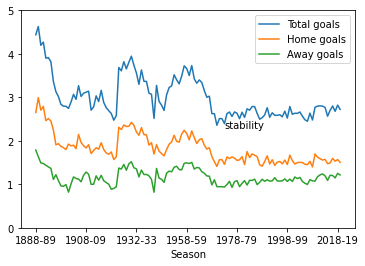

In [178]:
df = FootballData('1888-89', '2019-20').create_df()
df.groupby(['Season']).agg({'Total goals': 'mean', 'Home goals': 'mean', 'Away goals': 'mean'}).plot.line()
plt.ylim(0,5)
plt.annotate('stability', (75, 2.3))
plt.show()

We saw that since 1888, the average number of goals scored per game in the top flight of English football has decreased dramatically. From averaging almost 5 goals per game down to just under 3 goals per game in recent years. However, over the course of history we see that the trend is not linear, and that for about the first 75 years, goals per game is volatile. After, the number of goals begins to stabilise, and has gradually seen a subtle upwards trend over the past 50 or so years.

Looking at the breakdown of goals per game by goals scored by the home team vs. the away team, we see that home advantage also seems to be eroding as the modern game has become professionalised.

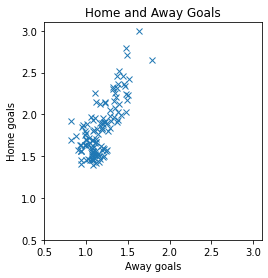

In [180]:
FootballData('1888-89', '2019-20').create_df()
df = df.groupby(['Season'], as_index = False).agg({'Away goals': 'mean', 'Home goals': 'mean'})

plt.figure().add_subplot().set_aspect('equal', adjustable = 'box')
plt.xlim(0.5,3.1)
plt.ylim(0.5,3.1)
plt.plot('Away goals', 'Home goals', data = df, linestyle = 'none', marker = 'x')
plt.title('Home and Away Goals')
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.show()

## The Big Six Teams of the Premier League Era: Compared

Using the flexibility afforded by the functions, we can quickly examine snapshots within the dataset. Let's look at the current iteration of the English top division, the Premier League, which had it's inaugural season in 1992-93.

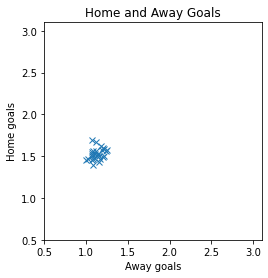

In [182]:
#Make a df starting from the inaugural season of the English Premier League
EPL = FootballData('1992-93', '2019-20').create_df()

EPL = EPL.groupby(['Season'], as_index = False).agg({'Away goals': 'mean', 'Home goals': 'mean'})

plt.figure().add_subplot().set_aspect('equal', adjustable = 'box')
plt.plot('Away goals', 'Home goals', data = EPL, linestyle = 'none', marker = 'x')
plt.title('Home and Away Goals')
plt.xlim(0.5,3.1)
plt.ylim(0.5,3.1)
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.show()

# C. The Sir Alex Ferguson Era

On 6th November 1986, Alex Ferguson was appointed the new manager of Manchester United. He would go on to manage the club for 27 years, leaving behind an era of unprecedented success in the domestic league.

While the Ferguson era was wildly successful, some analysis will illuminate just how successful and unprecedented this was. We will explore the following areas:
- Manchester United is known for attacking play and throwing caution to the wind - how true is this?
- Known for thrilling late comebacks and a never-say-die attitude


Let's start by creating a dataset of this era, from the 1986-87 to 2012-13 seasons, and adding in our team-specific data.

In [184]:
saf_era = FootballData('1986-87', '2012-13').get_team_stats('Manchester United')
#Note that Ferguson wasn't actually appointed until 13 games into the season, with his first game in charge coming against Oxford United on the 8th Nov, so we can acommodate for this if we would like:
saf_era = saf_era[13:]

display_n(saf_era, 3)

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Team,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
13,(Sat) 8 Nov 1986 (44),Oxford United FC (14),2-0,?,Manchester United FC (14),1986-87,2,2,0,NaN,...,Manchester United,0,NaN,NaN,2,NaN,NaN,-2,Loss,0
14,(Sat) 15 Nov 1986 (45),Norwich City FC (15),0-0,?,Manchester United FC (15),1986-87,0,0,0,NaN,...,Manchester United,0,NaN,NaN,0,NaN,NaN,0,Draw,1
15,(Sat) 22 Nov 1986 (46),Manchester United FC (16),1-0,?,Queens Park Rangers FC (16),1986-87,1,1,0,NaN,...,Manchester United,1,NaN,NaN,0,NaN,NaN,1,Win,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,(Sun) 5 May 2013 (W18),Manchester United FC (36),0-1,0-0,Chelsea FC (35),2012-13,1,0,1,0.0,...,Manchester United,0,0.0,0.0,1,0.0,1.0,-1,Loss,0
1046,(Sun) 12 May 2013 (W19),Manchester United FC (37),2-1,1-0,Swansea City AFC (37),2012-13,3,2,1,1.0,...,Manchester United,2,1.0,1.0,1,0.0,1.0,1,Win,3
1047,(Sun) 19 May 2013 (W20),West Bromwich Albion FC (38),5-5,1-3,Manchester United FC (38),2012-13,10,5,5,4.0,...,Manchester United,5,3.0,2.0,5,1.0,4.0,0,Draw,1


## The United Way

Now let's look at some visualisations which will help us explore the first question.

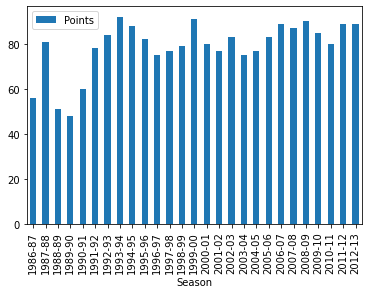

In [186]:
saf_era = FootballData('1986-87', '2012-13').get_team_stats('Manchester United')
saf_era.groupby(['Season']).agg({'Points': 'sum'}).plot.bar()
plt.show()

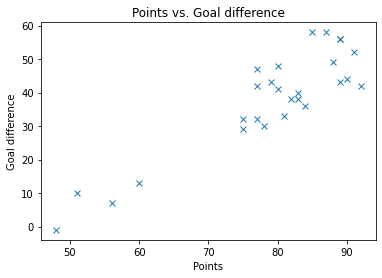

In [188]:
chart = saf_era.groupby(['Season']).agg({'Points': 'sum', 'Goal difference': 'sum'})
plt.plot('Points', 'Goal difference', data = chart, linestyle = 'none', marker = 'x')
plt.title('Points vs. Goal difference')
plt.xlabel('Points')
plt.ylabel('Goal difference')
plt.show()

Text(0, 0.5, 'Season')

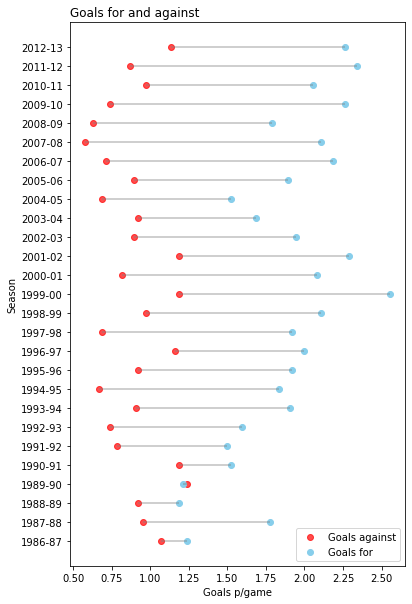

In [190]:
saf_era = saf_era.groupby(['Season'], as_index = False).agg({'Team goals': 'mean', 'Goals against': 'mean'})
season = saf_era['Season']

plt.figure(figsize = (6,10))
plt.hlines(y = season, xmin = saf_era['Goals against'], xmax = saf_era['Team goals'], color='grey', alpha=0.5)
plt.scatter(saf_era['Goals against'], season, color = 'red', alpha = 0.7, label = 'Goals against')
plt.scatter(saf_era['Team goals'], season, color = 'skyblue', alpha = 1, label = 'Goals for')
plt.legend()

plt.yticks(season, saf_era['Season'])
plt.title('Goals for and against', loc = 'left')
plt.xlabel('Goals p/game')
plt.ylabel('Season')

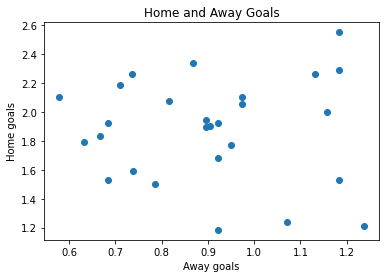

In [192]:
saf_era = saf_era.groupby(['Season'], as_index = False).agg({'Team goals': 'mean', 'Goals against': 'mean'})

plt.plot('Goals against', 'Team goals', data = saf_era, linestyle = 'none', marker = 'o')
plt.title('Home and Away Goals')
plt.xlabel('Away goals')
plt.ylabel('Home goals')
plt.show()

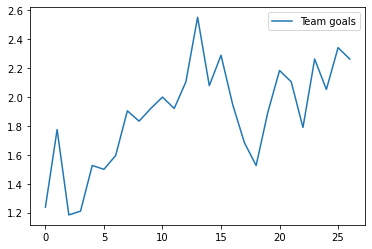

In [194]:
saf_era.groupby(['Season'], as_index = False).agg({'Team goals': 'mean'}).plot.line()

## Comeback Kings

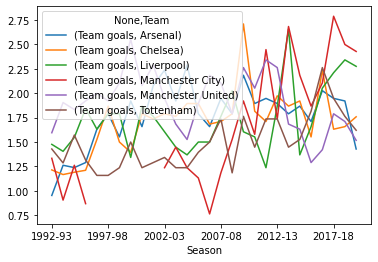

In [196]:
df = FootballData('1992-93', '2019-20').get_team_stats('Manchester United', 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Tottenham')
chart = df.groupby(['Season', 'Team'], as_index = False).agg({'Team goals': 'mean', 'Points': 'sum', 'Goal difference': 'sum'})
chart = chart.pivot_table(index = chart.Season, columns = ['Team'], values = ['Team goals']).plot()


Text(0, 0.5, 'Goals p/game')

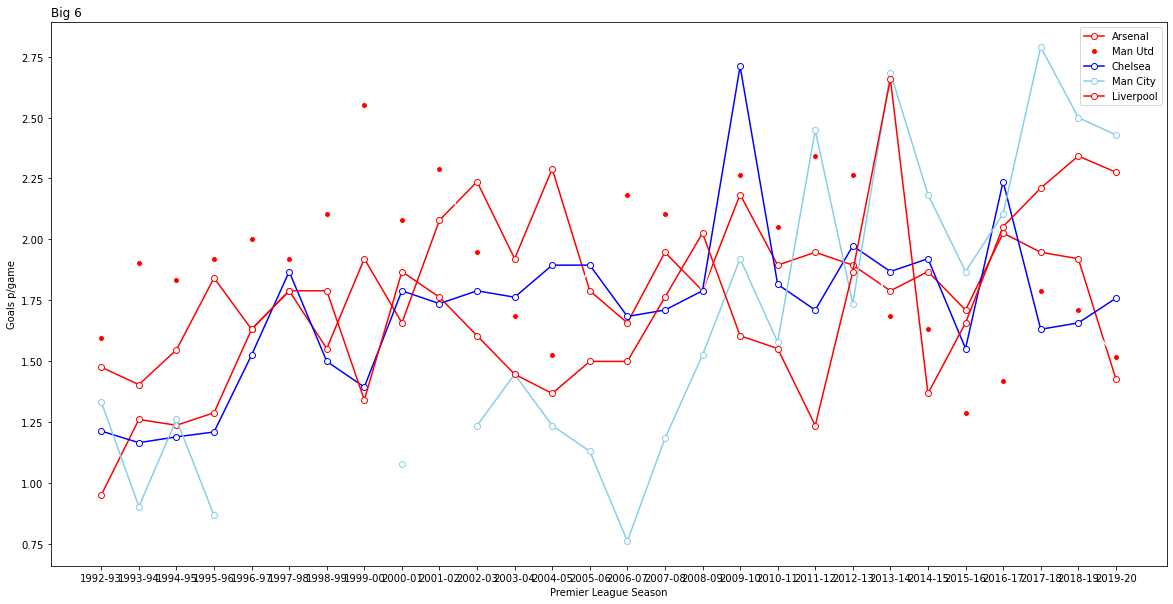

In [198]:
df = FootballData('1992-93', '2019-20').get_team_stats('Manchester United', 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Tottenham')
chart = df.groupby(['Season', 'Team'], as_index = False).agg({'Team goals': 'mean', 'Points': 'sum', 'Goal difference': 'sum'})
chart = chart.pivot_table(index = chart.Season, columns = ['Team'], values = ['Team goals'])

plt.figure(figsize=(20,10))
plt.plot(chart.index, chart['Team goals']['Arsenal'], label = "Arsenal", color = 'red', marker = 'o', markerfacecolor = 'white')
plt.plot(chart.index, chart['Team goals']['Manchester United'], label = "Man Utd", color = 'white', marker = 'o', markerfacecolor = 'red')
plt.plot(chart.index, chart['Team goals']['Chelsea'], label = "Chelsea", color = 'blue', marker = 'o', markerfacecolor = 'white')
plt.plot(chart.index, chart['Team goals']['Manchester City'], label = "Man City", color = 'skyblue', marker = 'o', markerfacecolor = 'white')
plt.plot(chart.index, chart['Team goals']['Liverpool'], label = "Liverpool", color = 'red', marker = 'o', markerfacecolor = 'white')
plt.legend()
plt.title('Big 6', loc = 'left')
plt.xlabel('Premier League Season')
plt.ylabel('Goals p/game')

In [200]:
df = FootballData('1888-89', '2019-20').get_team_stats('all')
df

,Date,Team 1,FT,HT,Team 2,Season,Total goals,Home goals,Away goals,First half goals,...,Team,Team goals,Team goals (1st half),Team goals (2nd half),Goals against,Goals against (1st half),Goals against (2nd half),Goal difference,Result,Points
0,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89,9,3,6,NaN,...,Bolton Wanderers FC,3,NaN,NaN,6,NaN,NaN,-3,Loss,0
1,(Sat) 8 Sep 1888 (36),Bolton Wanderers FC (1),3-6,?,Derby County FC (1),1888-89,9,3,6,NaN,...,Derby County FC,6,NaN,NaN,3,NaN,NaN,3,Win,3
2,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89,2,1,1,NaN,...,Wolverhampton Wanderers FC,1,NaN,NaN,1,NaN,NaN,0,Draw,1
3,(Sat) 8 Sep 1888 (36),Wolverhampton Wanderers FC (1),1-1,?,Aston Villa FC (1),1888-89,2,1,1,NaN,...,Aston Villa FC,1,NaN,NaN,1,NaN,NaN,0,Draw,1
4,(Sat) 8 Sep 1888 (36),Preston North End FC (1),5-2,?,Burnley FC (1),1888-89,7,5,2,NaN,...,Burnley FC,2,NaN,NaN,5,NaN,NaN,-3,Loss,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97799,(Sun) 8 Mar 2020 (W10),Chelsea FC (29),4-0,2-0,Everton FC (29),2019-20,4,4,0,2.0,...,Everton FC,0,0.0,0.0,4,2.0,2.0,-4,Loss,0
97800,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1.0,...,Manchester City FC,0,0.0,0.0,2,1.0,1.0,-2,Loss,0
97801,(Sun) 8 Mar 2020 (W10),Manchester United FC (29),2-0,1-0,Manchester City FC (28),2019-20,2,2,0,1.0,...,Manchester United FC,2,1.0,1.0,0,0.0,0.0,2,Win,3
97802,(Mon) 9 Mar 2020 (W11),Leicester City FC (29),4-0,1-0,Aston Villa FC (28),2019-20,4,4,0,1.0,...,Leicester City FC,4,1.0,3.0,0,0.0,0.0,4,Win,3


Over the entire history of English football teams have dropped in and out of the league and existence. The majority of today's teams did not exist at the time of the inaugural 1888-89 season. Let's narrow down the analysis by finding the top 20 teams in history who have been in the top division for the most seasons.

In [207]:
df = FootballData('1888-89', '2019-20').get_team_stats('all')
df = df.groupby(['Team'])['Season'].nunique().sort_values(ascending=False)
df.head(20)

Team
Everton FC                    118
Aston Villa FC                107
Liverpool FC                  106
Arsenal FC                    104
Manchester United FC           96
Manchester City FC             91
Newcastle United FC            88
Sunderland AFC                 87
Chelsea FC                     86
Tottenham Hotspur FC           85
West Bromwich Albion FC        80
Bolton Wanderers FC            74
Blackburn Rovers FC            73
Wolverhampton Wanderers FC     66
Derby County FC                66
Sheffield Wednesday FC         66
Stoke City FC                  63
West Ham United FC             62
Middlesbrough FC               62
Sheffield United FC            62
Name: Season, dtype: int64

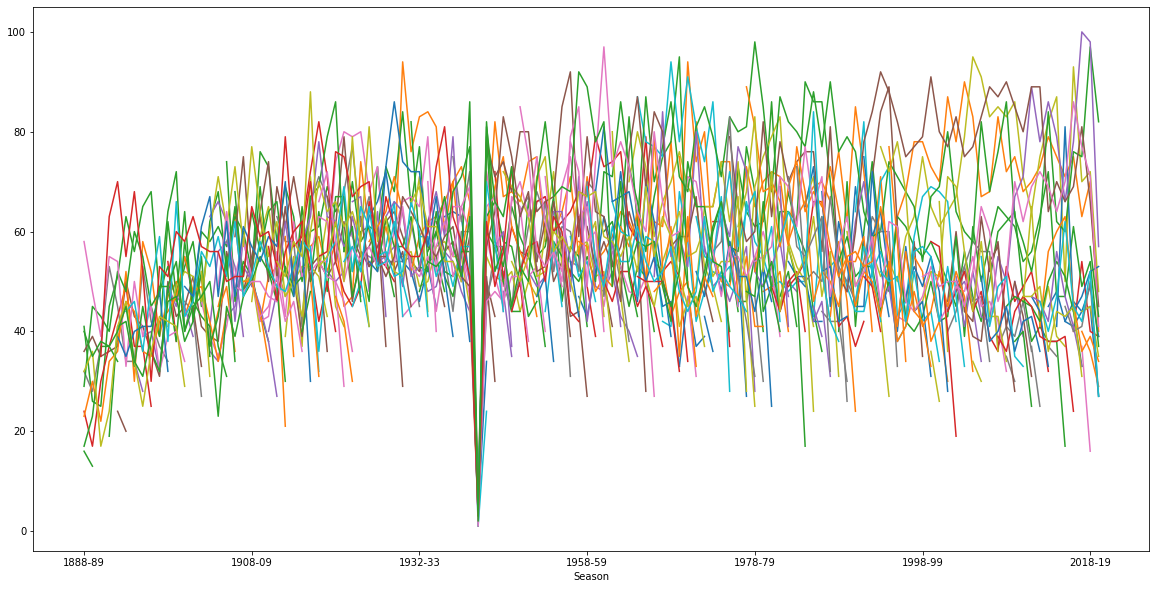

In [203]:
df = FootballData('1888-89', '2019-20').get_team_stats('all')
chart = df.groupby(['Season', 'Team'], as_index = False).agg({'Team goals': 'mean', 'Points': 'sum', 'Goal difference': 'sum'})
chart = chart.pivot_table(index = chart.Season, columns = ['Team'], values = ['Points']).plot(legend=False, figsize=(20,10))

# Final Thoughts (visualised)

Pulling it all together, let's construct some visualisations designed to communicate some headline thoughts. For this we will use the seaborn library for its superior aesthetic/design capabilities.

## The Ferguson era was unprecedented

*Description/caption with the data observation*

In [204]:
import seaborn as sns

In [205]:
df = merge_df('1986-87', '2019-20')
df = add_columns(df[13:])
df = find_team_games(df, 'Manchester United').reset_index(drop=True)
#Now let's add team statistics for Ferguson's United teams
df = team_stats(df, 'Manchester United')
df = df.groupby(['Season'], as_index = False).agg({'Team goals': 'mean', 'Goals against': 'mean'})
season = df['Season']

plt.figure(figsize = (6,10))
plt.hlines(y = season, xmin = df['Goals against'], xmax = df['Team goals'], color='grey', alpha=0.5)
plt.scatter(df['Goals against'], season, color = 'red', alpha = 0.7, label = 'Goals against')
plt.scatter(df['Team goals'], season, color = 'skyblue', alpha = 1, label = 'Goals for')
plt.legend()

plt.yticks(season, df['Season'])
plt.title('Goals for and against', loc = 'left')
plt.xlabel('Goals p/game')
plt.ylabel('Season')

NameError: name 'team_stats' is not defined